# Amazon forest analysis from satellite images.


Data obtained from the kaggle competition https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/

## Visualize whats happening in the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# base_path = '/media/anant/data/amazon_from_space/'
base_path = '/media/avemuri/DEV/Data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### Plot the frequency of each label

In [31]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'selective_logging', 'bare_ground', 'agriculture', 'clear', 'habitation', 'haze', 'slash_burn', 'cloudy', 'blooming', 'cultivation', 'water', 'primary', 'conventional_mine', 'blow_down', 'road', 'artisinal_mine', 'partly_cloudy'}


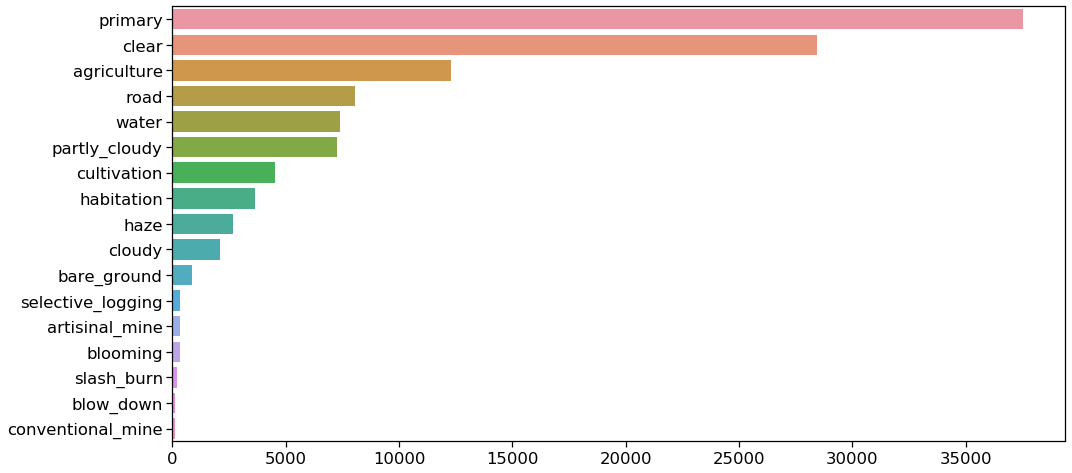

In [32]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [33]:
percentages = labels_s

In [4]:
def plot_torch_image(x, y):
    for j in range(3):
        img = np.moveaxis(x.numpy().squeeze(), (0,1,2), (2,0,1))
        for i in range(3):
            img[:,:,i] = (img[:,:,i] - img[:,:,i].min()) / (img[:,:,i].max() - img[:,:,i].min())
        # print(min(img.flatten()), max(img.flatten()))
    _ = plt.figure()
    _ = plt.imshow(img)
    # print(img.dtype)
    print(y)

## Imports for training

In [5]:
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models

from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Accuracy, Precision, Recall, Loss, Metric
# from ignite.contrib.handlers import CosineAnnealingScheduler
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler

## Get data

In [6]:
def get_split_data():
    image_list = [f for f in glob.glob(base_path+'train-jpg'+'/*.jpg')]
    SPLIT = 0.2
    dataset_size = len(image_list)
    indices = list(range(dataset_size))
    split = int(np.floor(SPLIT * dataset_size))

    np.random.seed(42)
    np.random.shuffle(indices)

    train_indices, valid_indices = indices[split:], indices[:split]
    df_train = pd.read_csv(base_path+'train_v2.csv')
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(df_train['tags'].str.split()).astype(np.float32)
    image_paths = []
    for f, tags in tqdm_notebook(df_train.values, miniters=1000, desc="TRAIN SET"):
        image_paths.append(base_path+'train-jpg'+'/'+'{}.jpg'.format(f))
        
    return image_paths, labels, train_indices, valid_indices, mlb

image_paths, labels, train_indices, valid_indices, mlb = get_split_data()
print(len(image_paths), labels.shape)


40479 (40479, 17)


In [7]:
def get_test_data():
    
    _, _, _, _, mlb = get_split_data()
    
    df = pd.read_csv(base_path+'sample_submission_v2.csv')
    image_names = df['image_name'].values
    
#     image_list = [f for f in glob.glob(base_path+'test-jpg'+'/*.jpg')]
    
    image_paths = []
    for file_name in tqdm_notebook(image_names, desc='TEST SET'):
        image_paths.append(base_path+'test-jpg'+'/'+'{}.jpg'.format(file_name))
    
#     for f in tqdm_notebook(list(range(len(image_list))), miniters=1000, desc="TEST SET"):
#         image_paths.append(base_path+'test-jpg'+'/'+'{}.jpg'.format(f))
        
#     image_list_additional = [f for f in glob.glob(base_path+'test-jpg-additional'+'/*.jpg')]
        
#     for f in tqdm_notebook(list(range(len(image_list_additional))), miniters=1000, desc="TEST SET ADDITIONAL"):
#         image_paths.append(base_path+'test-jpg-additional'+'/'+'{}.jpg'.format(f))
        
    return image_paths, mlb

image_test_paths, mlb = get_test_data()
print(len(image_test_paths))


61191


### Get data as numpy array

In [38]:
def get_data(image_paths, labels, image_size=(32, 32)):
    
    X = []
    y = []
    
    for f, label in tqdm_notebook(zip(image_paths, labels), miniters=1000, total=len(labels)):
        img = cv2.imread(f)
        X.append(cv2.resize(img, image_size))
        y.append(label)
    
    
    
    y = np.array(y, np.uint8)
    X = np.array(X, np.float16) / 255.
                         
    return X, y

In [ ]:
X, y = get_data(image_paths, labels, (32, 32))

In [30]:
X = np.moveaxis(X, (0,1,2,3), (0,2,3,1))
print(X.shape, y.shape)

(40479, 3, 32, 32) (40479, 17)


In [31]:
x_train, y_train = X[train_indices], y[train_indices]
x_valid, y_valid = X[valid_indices], y[valid_indices]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(32384, 3, 32, 32) (32384, 17) (8095, 3, 32, 32) (8095, 17)


In [32]:
train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
valid_dataset = TensorDataset(torch.from_numpy(x_valid).float(), torch.from_numpy(y_valid).float())

In [33]:
import matplotlib.pyplot as plt

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.])


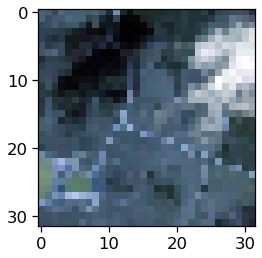

In [34]:
x, y = train_dataset[0]
plot_torch_image(x,y)

### Get data from pytorch dataset object

In [8]:
class AmazonDataset(Dataset):
    def __init__(self, image_paths, labels=None, select_indices=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        if select_indices is not None:
            if self.labels is not None:
                self.labels = self.labels[select_indices]
            self.image_paths = list(np.array(self.image_paths)[select_indices])
            
        self.length = len(self.image_paths)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        #file_name = self.base_path+'train-jpg'+'/'+'{}.jpg'.format(self.image_names[index])
        #image = Image.open(file_name)
        #image = image.convert('RGB')
        #print(self.image_paths[index])
        #print(self.labels[index])
        #print(self.image_paths[index])
        image = cv2.imread(self.image_paths[index])
        if self.labels is not None:
            label = torch.from_numpy(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.labels is not None:
            return image, label
        else:
            return image


In [9]:
IMG_SIZE = (100, 100)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_transform_augmented = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(IMG_SIZE, Image.NEAREST),
                                                transforms.ColorJitter(brightness=0.5),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomResizedCrop(IMG_SIZE, 
                                                                             scale=(0.7, 1.0), 
                                                                             ratio=(1.0,1.0), 
                                                                             interpolation=Image.NEAREST),
                                                transforms.ToTensor(),
                                                normalize])
valid_transform_augmented = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(IMG_SIZE, Image.NEAREST),
                                                transforms.ToTensor(),
                                                normalize])

In [10]:
train_dataset = AmazonDataset(image_paths, labels, select_indices=train_indices,
                                 transform=train_transform_augmented)
valid_dataset = AmazonDataset(image_paths, labels, select_indices=valid_indices,
                                 transform=valid_transform_augmented)
test_dataset = AmazonDataset(image_test_paths, transform=valid_transform_augmented)

print(len(train_indices), len(valid_indices), len(train_dataset), len(valid_dataset), len(test_dataset))

32384 8095 32384 8095 61191


tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.])


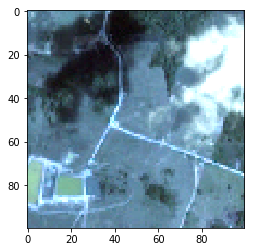

In [11]:
x, y = train_dataset[0]
plot_torch_image(x, y)

### Create dataloaders

In [12]:
BATCH_SIZE = 128
SHUFFLE = True

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

print(len(train_loader), len(valid_loader), len(test_loader))

253 64 479


In [13]:
# for x, y in train_loader:
#     print(x.shape, y.shape)

for i in range(2):
    x, y = next(iter(train_loader))
    print(x.shape, y.shape)
    

torch.Size([128, 3, 100, 100]) torch.Size([128, 17])
torch.Size([128, 3, 100, 100]) torch.Size([128, 17])


## Model definition

In [14]:
class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False): 
        super(Flatten, self).__init__()
        self.full = full
    def forward(self, x): return x.view(-1) if self.full else x.view(x.size(0), -1)

In [15]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super(AdaptiveConcatPool2d, self).__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

### Basic model

In [16]:
# class BaseNet(nn.Module):
#     def __init__(self):
#         super(BaseNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(2304, 256)
#         self.fc2 = nn.Linear(256, 17)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(x.size(0), -1) # Flatten layer
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return torch.sigmoid(x)

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv12 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv13 = nn.Conv2d(64, 128, kernel_size=3)
        
        self.conv21 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv22 = nn.Conv2d(256, 512, kernel_size=3)
        self.conv23 = nn.Conv2d(512, 1024, kernel_size=3)
        
        self.conv2_drop_1 = nn.Dropout2d(0.25)
        self.conv2_drop_2 = nn.Dropout2d(0.25)
        self.linear_drop_1 = nn.Dropout(0.5)
        self.linear_drop_2 = nn.Dropout(0.5)
        
        self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((1,1))
        
        # self.fc1 = nn.Linear(9216, 256)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 17)
        #self.fc4 = nn.Linear(32, 17)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.conv2_drop_1(F.max_pool2d(F.relu(self.conv13(x)), (2,2)))
        
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.conv2_drop_2(F.max_pool2d(F.relu(self.conv23(x)), (2,2)))
        
        x = self.adaptive_avg_pool2d(x)
        x = x.view(x.size(0), -1) # Flatten layer
        # print(x.shape)
        
        x = F.relu(self.fc1(x))
        x = self.linear_drop_1(x)
        x = F.relu(self.fc2(x))
        x = self.linear_drop_2(x)
        x = self.fc3(x)
        
        #x = self.fc4(x)
        
        return torch.sigmoid(x)

In [49]:
img = torch.from_numpy(np.random.randn(3,3,32,32)).float()
print(img.shape)
model = BaseNet()
out = model(img)
print(out.shape)

torch.Size([3, 3, 32, 32])
torch.Size([3, 17])


### Advanced model

In [17]:
class AdvancedNet(nn.Module):
    def __init__(self, output_features, cut=-2):
        super(AdvancedNet, self).__init__()
        # model = models.resnet50(pretrained=True)
        pretrained = models.resnet50(pretrained=True)
        num_ftrs = 2*pretrained.fc.in_features                      # 2* since we are usng AdaptiveConcatPool2d
        
        self.body = nn.Sequential(*list(pretrained.children())[:cut])
        self.head = nn.Sequential(AdaptiveConcatPool2d(), 
                                  Flatten(),
                                  nn.Linear(num_ftrs, 512),
                                  nn.BatchNorm1d(512),
                                  nn.ReLU(),
                                  nn.Dropout2d(0.5),
                                  nn.Linear(512,output_features)
#                                   nn.BatchNorm1d(256),
#                                   nn.ReLU(),
#                                   nn.Dropout2d(0.5),
#                                   nn.Linear(256,128),
#                                   nn.BatchNorm1d(128),
#                                   nn.ReLU(),
#                                   nn.Dropout2d(0.5),
#                                   nn.Linear(128,output_features)
                                 )
                                 
#         self.model = model
        
    def forward(self, x):
        return torch.sigmoid(self.head(self.body(x)))
    
    def freeze_pretrain(self, last_how_many=1):
        for parameter in self.body.parameters():
            parameter.requires_grad = False
        ### Set requires_grad to True for last block ###
        length_of_body = len(list(self.body.children()))
        ct = 0
        for child in self.body.children():
            ct += 1
            if ct <= length_of_body-last_how_many:
                for param in child.parameters():
                    param.requires_grad = False
        
        for paramter in self.head.parameters():
            parameter.requires_grad = True
    
    def freeze(self):
        for parameter in self.body.parameters():
            parameter.requires_grad = False
        for paramter in self.head.parameters():
            parameter.requires_grad = True
            
    def unfreeze(self):
        for parameter in self.body.parameters():
            parameter.requires_grad = True
        for paramter in self.head.parameters():
            parameter.requires_grad = True

# class AdvancedNet(nn.Module):
#     def __init__(self):
#         super(AdvancedNet, self).__init__()
        
#         pretrained_model = models.resnet34(pretrained=True)
#         self.pretrained_model = nn.Sequential(*list(pretrained_model.children())[0:9])
        
            
#         self.additional_stacked_layers = nn.Sequential(nn.Linear(512, 17))
# #                                                        ,
# #                                                        nn.ReLU(inplace=True),
# #                                                        nn.Dropout2d(0.5),
# #                                                        nn.Linear(256, 128),
# #                                                        nn.ReLU(inplace=True),
# #                                                        nn.Linear(128, 64),
# #                                                        nn.ReLU(inplace=True),
# #                                                        nn.Dropout2d(0.5),
# #                                                        nn.Linear(64, 17))
        
        
# #         self.classifier = nn.Sequential(self.pretrained_model,
# #                                         self.additional_stacked_layers)
        

#     def forward(self, x):
#         x = self.pretrained_model(x)
#         x = x.view(x.size(0), -1) # Flatten layer
#         x = self.additional_stacked_layers(x)
#         return torch.sigmoid(x)
    
#     def freeze(self):
#         for parameter in self.pretrained_model.parameters():
#             parameter.requires_grad = False
            
#     def unfreeze(self):
#         for parameter in self.pretrained_model.parameters():
#             parameter.requires_grad = True
            
        
        

In [18]:
img = torch.from_numpy(np.random.randn(3,3,32,32)).float()
print(img.shape)
model = AdvancedNet(17)
model = model.eval()
out = model(img)
print(out.shape)

torch.Size([3, 3, 32, 32])
torch.Size([3, 17])


## Metrics

In [19]:
def thresholded_output_transform(output, threshold=0.5):
    y_pred, y = output
    # y_pred = torch.ge(y_pred.float(), threshold).float()
    # one_tensor = torch.tensor([1]).cuda()
    # zero_tensor = torch.tensor([0]).cuda()
    # y_pred = torch.where(y_pred>0.4, one_tensor, zero_tensor)
    y_pred = torch.round(y_pred)
    return y_pred, y

In [41]:
class KerasMetrics:
	def precision(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		predicted_positives = k.backend.sum(k.backend.round(k.backend.clip(y_pred, 0, 1)))
		precision = true_positives / (predicted_positives + k.backend.epsilon())
		return precision

	def recall(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		possible_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1)))
		recall = true_positives / (possible_positives + k.backend.epsilon())
		return recall

	def fbeta_score(self, y_true, y_pred, beta=2):
		if beta < 0:
			raise ValueError('The lowest choosable beta is zero (only precision).')

		if k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1))) == 0:
			return 0

		p = self.precision(y_true, y_pred)
		r = self.recall(y_true, y_pred)
		bb = beta ** 2
		fbeta_score = (1 + bb) * (p * r) / (bb * p + r + k.backend.epsilon())
		return fbeta_score

In [20]:
class FBetaScore(Metric):
    """
    Calculate the fbeta score.

    - `update` must receive output of the form `(y_pred, y)`.
    """
    def __init__(self, beta=2, output_transform=lambda x: x, average=False, is_multilabel=False):
        self.precision = Precision(output_transform=output_transform, 
                                   average=average, is_multilabel=is_multilabel)
        self.recall = Recall(output_transform=output_transform,
                             average=average, is_multilabel=is_multilabel)
        
        super(FBetaScore, self).__init__(output_transform)
        self.beta = beta
        

    def reset(self):
        self.precision.reset()
        self.recall.reset()

    def update(self, output):
        self.precision.update(output)
        self.recall.update(output)

    def compute(self):
        p = self.precision.compute()
        r = self.recall.compute()
        bb = self.beta ** 2
        fbeta_score = ((1 + bb) * (p * r) / (bb * p + r + 1e-07)).mean().item()
        return fbeta_score

In [95]:
def fbeta_score(y_true, y_pred, beta=2, threshold=0.5, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [96]:
def custom_loss(y_true, y_pred):
    loss_bce = F.binary_cross_entropy(y_true, y_pred)
    loss_fbeta = fbeta_score(y_true, y_pred, beta=2, threshold=0.5)
    
    return loss_bce+(1-loss_fbeta)

## Model definition

### Model definition: simple model

In [40]:
model = BaseNet()

### Model definition: advanced model

In [21]:
model = AdvancedNet(output_features=17)

## Training

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(trainer):
#     iteration = trainer.state.iteration
#     if iteration%100 == 0:
#         epoch = trainer.state.epoch
#         loss = trainer.state.output
#         print("Epoch: {0} Iteration: {1} Loss: {2}".format(epoch, iteration, loss))

def create_callbacks(trainer):
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        loss = trainer.state.output
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics

    #     print("Training Results - Epoch: {0}  Training loss: {2}"
    #           .format(trainer.state.epoch,
    #                   loss))
#         print("Training Results - Epoch: {}  Training loss: {:.2f} Avg accuracy: {:.2f} Avg loss: {:.2f}  Avg Recall: {:.2f}  Avg Precision: {:.2f}  Avg fbeta: {:.2f}"
#               .format(trainer.state.epoch,
#                       loss,
#                       metrics['accuracy'], 
#                       metrics['loss'],
#                       metrics['recall'],
#                       metrics['precision'],
#                       metrics['fbeta']))
        
#         print("Training Results - Epoch: {}  Training loss: {:.2f} Avg loss: {:.2f} Avg accuracy: {:.2f} Avg recall: {:.2f} Avg precision: {:.2f}".format(trainer.state.epoch,loss, metrics['loss'],
#                                                                                                                  metrics['accuracy'], 
#                                                                                                                  metrics['recall'],
#                                                                                                                  metrics['precision']))

        print("Training Results - Epoch: {}  Training loss: {:.2f} Avg loss: {:.2f} Avg accuracy: {:.2f} Avg recall: {:.2f} Avg precision: {:.2f} Avg fbeta: {:.2f}"
              .format(trainer.state.epoch, 
                      loss, 
                      metrics['loss'], 
                      metrics['accuracy'], 
                      metrics['recall'], 
                      metrics['precision'], 
                      metrics['fbeta']))

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_evaluator_on_validation_data(engine):
        evaluator.run(valid_loader)

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_trainer_on_training_data(engine):
        evaluator.run(train_loader)
        #print("Epoch: {0} Loss: {1}".format(epoch, loss)) 

### Freeze to pretrain linear layer and perform warmup

In [24]:
is_multilabel = False
average = True

In [25]:
model.freeze_pretrain()

In [26]:
LR_START = 0.0001
LR_STOP = 1e-5
LR_BASE = LR_START
optimizer = torch.optim.Adam(model.parameters(), lr=LR_BASE)
trainer = create_supervised_trainer(model, optimizer, F.binary_cross_entropy, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'loss': Loss(F.binary_cross_entropy),
                                                                       'accuracy': Accuracy(thresholded_output_transform, 
                                                                                            is_multilabel=is_multilabel),
                                                                       'recall': Recall(thresholded_output_transform, 
                                                                                        is_multilabel=is_multilabel,
                                                                                        average=average),
                                                                       'precision': Precision(thresholded_output_transform, 
                                                                                              is_multilabel=is_multilabel,
                                                                                              average=average),
                                                                       'fbeta': FBetaScore(output_transform=thresholded_output_transform, 
                                                                                           is_multilabel=is_multilabel)})

create_callbacks(trainer)

In [27]:
trainer.run(train_loader, max_epochs=1)

Training Results - Epoch: 1  Training loss: 0.18 Avg loss: 0.17 Avg accuracy: 0.95 Avg recall: 0.77 Avg precision: 0.89 Avg fbeta: 0.79


### Freeze to pretrain linear layer

In [28]:
is_multilabel = False
average = True

In [29]:
model.freeze()

In [30]:
LR_START = 0.0005
LR_STOP = 1e-5
LR_BASE = LR_START
optimizer = torch.optim.Adam(model.parameters(), lr=LR_BASE)
trainer = create_supervised_trainer(model, optimizer, F.binary_cross_entropy, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'loss': Loss(F.binary_cross_entropy),
                                                                       'accuracy': Accuracy(thresholded_output_transform, 
                                                                                            is_multilabel=is_multilabel),
                                                                       'recall': Recall(thresholded_output_transform, 
                                                                                        is_multilabel=is_multilabel,
                                                                                        average=average),
                                                                       'precision': Precision(thresholded_output_transform, 
                                                                                              is_multilabel=is_multilabel,
                                                                                              average=average),
                                                                       'fbeta': FBetaScore(output_transform=thresholded_output_transform, 
                                                                                           is_multilabel=is_multilabel)})
                                                                       
scheduler = CosineAnnealingScheduler(optimizer, 'lr', start_value=LR_START, end_value=LR_STOP,
                                     cycle_size=len(train_dataset), cycle_mult=1.0,
                                     start_value_mult=0.95, end_value_mult=1.0)
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# trainer.add_event_handler(Events.ITERATION_COMPLETED, save_lr)

create_callbacks(trainer)

In [31]:
trainer.run(train_loader, max_epochs=5)

Training Results - Epoch: 1  Training loss: 0.14 Avg loss: 0.13 Avg accuracy: 0.95 Avg recall: 0.78 Avg precision: 0.90 Avg fbeta: 0.81
Training Results - Epoch: 2  Training loss: 0.14 Avg loss: 0.13 Avg accuracy: 0.95 Avg recall: 0.80 Avg precision: 0.89 Avg fbeta: 0.82
Training Results - Epoch: 3  Training loss: 0.13 Avg loss: 0.13 Avg accuracy: 0.95 Avg recall: 0.79 Avg precision: 0.90 Avg fbeta: 0.81
Training Results - Epoch: 4  Training loss: 0.13 Avg loss: 0.12 Avg accuracy: 0.95 Avg recall: 0.79 Avg precision: 0.91 Avg fbeta: 0.81
Training Results - Epoch: 5  Training loss: 0.12 Avg loss: 0.12 Avg accuracy: 0.95 Avg recall: 0.82 Avg precision: 0.89 Avg fbeta: 0.83


### Unfreeze perform warmup training

In [32]:
is_multilabel = False
average = True

In [33]:
model.unfreeze()

In [34]:
LR_START = 0.0005
LR_STOP = 1e-5
LR_BASE = LR_START
optimizer = torch.optim.Adam(model.parameters(), lr=LR_BASE)
trainer = create_supervised_trainer(model, optimizer, F.binary_cross_entropy, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'loss': Loss(F.binary_cross_entropy),
                                                                       'accuracy': Accuracy(thresholded_output_transform, 
                                                                                            is_multilabel=is_multilabel),
                                                                       'recall': Recall(thresholded_output_transform, 
                                                                                        is_multilabel=is_multilabel,
                                                                                        average=average),
                                                                       'precision': Precision(thresholded_output_transform, 
                                                                                              is_multilabel=is_multilabel,
                                                                                              average=average),
                                                                       'fbeta': FBetaScore(output_transform=thresholded_output_transform, 
                                                                                           is_multilabel=is_multilabel)})

create_callbacks(trainer)

In [35]:
trainer.run(train_loader, max_epochs=1)

Training Results - Epoch: 1  Training loss: 0.11 Avg loss: 0.10 Avg accuracy: 0.96 Avg recall: 0.85 Avg precision: 0.91 Avg fbeta: 0.86


### Unfreeze to train the complete model

In [38]:
LR_START = 0.00005
LR_STOP = 1e-5
LR_BASE = LR_START
optimizer = torch.optim.Adam(model.parameters(), lr=LR_BASE)
trainer = create_supervised_trainer(model, optimizer, F.binary_cross_entropy, device=device)
evaluator = create_supervised_evaluator(model, device=device, metrics={'loss': Loss(F.binary_cross_entropy),
                                                                       'accuracy': Accuracy(thresholded_output_transform, 
                                                                                            is_multilabel=is_multilabel),
                                                                       'recall': Recall(thresholded_output_transform, 
                                                                                        is_multilabel=is_multilabel,
                                                                                        average=average),
                                                                       'precision': Precision(thresholded_output_transform, 
                                                                                              is_multilabel=is_multilabel,
                                                                                              average=average),
                                                                       'fbeta': FBetaScore(output_transform=thresholded_output_transform, 
                                                                                           is_multilabel=is_multilabel)})
                                                                       
scheduler = CosineAnnealingScheduler(optimizer, 'lr', start_value=LR_START, end_value=LR_STOP,
                                     cycle_size=len(train_dataset), cycle_mult=1.0,
                                     start_value_mult=1.0)
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# # trainer.add_event_handler(Events.ITERATION_COMPLETED, save_lr)

create_callbacks(trainer)

In [37]:
trainer.run(train_loader, max_epochs=10)

Training Results - Epoch: 1  Training loss: 0.11 Avg loss: 0.10 Avg accuracy: 0.96 Avg recall: 0.84 Avg precision: 0.92 Avg fbeta: 0.85
Training Results - Epoch: 2  Training loss: 0.12 Avg loss: 0.10 Avg accuracy: 0.96 Avg recall: 0.84 Avg precision: 0.92 Avg fbeta: 0.86
Training Results - Epoch: 3  Training loss: 0.09 Avg loss: 0.09 Avg accuracy: 0.96 Avg recall: 0.87 Avg precision: 0.92 Avg fbeta: 0.87
Training Results - Epoch: 4  Training loss: 0.12 Avg loss: 0.10 Avg accuracy: 0.96 Avg recall: 0.86 Avg precision: 0.91 Avg fbeta: 0.87
Training Results - Epoch: 5  Training loss: 0.12 Avg loss: 0.09 Avg accuracy: 0.97 Avg recall: 0.87 Avg precision: 0.92 Avg fbeta: 0.88
Training Results - Epoch: 6  Training loss: 0.09 Avg loss: 0.09 Avg accuracy: 0.96 Avg recall: 0.86 Avg precision: 0.93 Avg fbeta: 0.87
Training Results - Epoch: 7  Training loss: 0.09 Avg loss: 0.09 Avg accuracy: 0.97 Avg recall: 0.87 Avg precision: 0.93 Avg fbeta: 0.88
Training Results - Epoch: 8  Training loss: 0.10

## Testing

### Evaluate on test data

In [39]:
y_test_pred = []
with torch.no_grad():
    model = model.eval()
    for i, x in enumerate(tqdm_notebook(test_loader)):
        x = x.to(device)
        y_test_pred.append(model(x).cpu().numpy())
        
y_test_pred = np.vstack(y_test_pred)
y_test_pred_COPY = y_test_pred

### Save test predictions 

In [40]:
prediction_threshold = 0.4
y_test_pred = y_test_pred_COPY

In [41]:
y_test_pred[y_test_pred<prediction_threshold] = 0
y_test_pred[y_test_pred>prediction_threshold] = 1
# print(y_test_pred[0])
y_preds_tuple = mlb.inverse_transform(y_test_pred)
print(y_preds_tuple[0])

('clear', 'primary')


### Transform predictions to string

In [42]:
y_preds_str = []
for preds in y_preds_tuple:
    string_val = ''
    for i, value in enumerate(preds):
        string_val = string_val + value
        if i < len(preds)-1:
            string_val = string_val + ' '
    y_preds_str.append(string_val)
    
print(len(y_preds_str))
print(y_preds_str[10])

61191
partly_cloudy primary


### Get image test names

In [43]:
y_test_name = []
for file_path in tqdm_notebook(image_test_paths):
    file_name = os.path.splitext(os.path.split(file_path)[1])[0]
    y_test_name.append(file_name)
y_test_name = np.array(y_test_name)
print(y_test_name.shape)


(61191,)


### Save predictions and file names to dataframe

In [44]:
df = pd.DataFrame()
df['image_name'] = y_test_name
df['tags'] = y_preds_str
df.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,cloudy partly_cloudy primary


### Save results to file

In [45]:
df.to_csv(base_path+'test_result.csv', index=False)